In [1]:
from astropy.table import Table
from astroquery.vizier import Vizier

from matplotlib import pyplot
import numpy
import pandas
import seaborn

from pathlib import Path

from targets import TARGETS

In [2]:
try:
    usno = Table.read('data/usno.ecsv')
except FileNotFoundError:
    Vizier.ROW_LIMIT = 1e6
    usno = Vizier.get_catalogs('I/284/out')[0]
    usno.write('data/usno.ecsv')
usno['B - R'] = usno['B1mag'] - usno['R1mag']
usno['R - I'] = usno['R1mag'] - usno['Imag']
usno['target'] = 'USNO'
usno['type'] = 'USNO'

In [3]:
try:
    nomad = Table.read('data/nomad.ecsv')
except FileNotFoundError:
    Vizier.ROW_LIMIT = 1e6
    nomad = Vizier.get_catalogs('I/297/out')[0]
    nomad.write('data/nomad.ecsv')
nomad['B - V'] = nomad['Bmag'] - nomad['Vmag']
nomad['V - R'] = nomad['Vmag'] - nomad['Rmag']
nomad['target'] = 'NOMAD'
nomad['type'] = 'NOMAD'

In [4]:
target_means = {
    'type': 'OU',
    'target': [],
    'R - I': [],
    'B - R': [],
    'B - V': [],
    'V - R': [],
}
for table in Path('data').glob('target_observations/*.ecsv'):
    if table.stem not in TARGETS:
        continue
    photometry = Table.read(table)
    photometry = photometry[photometry['FLAGS'] == 0]
    photometry = photometry.to_pandas()
    if 'calibrated magnitude' not in photometry.keys():
        continue
    photometry['calibrated magnitude'] = photometry['calibrated magnitude'].apply(lambda m: float(m) if m is not None else None)
    band_means = photometry.groupby('band').mean()['calibrated magnitude']
    if len(band_means) == 0:
        continue
    target_means['target'].append(table.stem)
    target_means['R - I'].append(band_means['R'] - band_means['I'])
    target_means['B - R'].append(band_means['B'] - band_means['R'])
    target_means['B - V'].append(band_means['B'] - band_means['V'])
    target_means['V - R'].append(band_means['V'] - band_means['R'])

df = pandas.concat([
    usno.to_pandas().sample(10000),
    nomad.to_pandas().sample(10000),
    pandas.DataFrame(target_means),
])

(-2.0, 4.0)

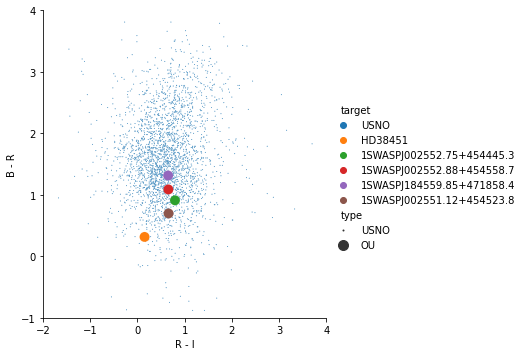

In [5]:
seaborn.relplot(
    data=df[df['type'] != 'NOMAD'],
    x='R - I',
    y='B - R',
    hue='target',
    size='type',
    sizes={'OU': 100, 'USNO': 1},
)
pyplot.ylim((-1, 4))
pyplot.xlim((-2, 4))

(-2.0, 2.0)

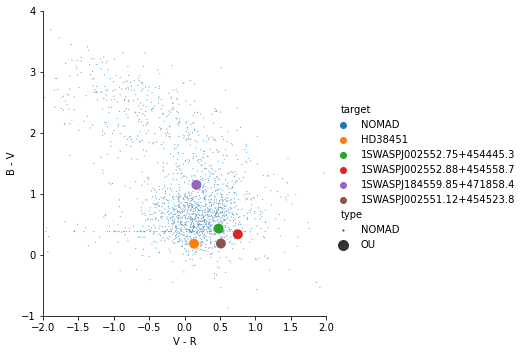

In [6]:
seaborn.relplot(
    data=df[df['type'] != 'USNO'],
    x='V - R',
    y='B - V',
    hue='target',
    size='type',
    sizes={'OU': 100, 'NOMAD': 1},
)
pyplot.ylim((-1, 4))
pyplot.xlim((-2, 2))